In [9]:
import ants
import numpy as np
import os
from pathlib import Path
import nibabel as nb
from matplotlib import pyplot as plt


In [52]:
output_dir = Path("/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/mbPCASLhr_reg_XXX")

in_dir = Path("/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/mbPCASLhr")
in_fname = "HCA6010538_pCASL_bet_mean.nii.gz"

in_dir = Path("/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/")
in_fname = "out.nii.gz"

source = in_dir / in_fname

target_dir = Path("/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/T2w_SPC_vNav")
target_fname = "HCA6010538_V1_MR_T2w_SPC_vNav_bet.nii.gz"
target = target_dir / target_fname
print(source)
print(target)
t1 = ants.image_read(str(target))

/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/out.nii.gz
/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/T2w_SPC_vNav/HCA6010538_V1_MR_T2w_SPC_vNav_bet.nii.gz


In [ ]:
# #ants does not apply the scaling factors from the header, but nibabel does
# # if we do not do this registration fails
# d = nb.load(str(source)).get_fdata()
# print(d.max())
# source_img_ants = ants.image_read(str(target))
# source_img = ants.from_numpy(d,
#                              spacing=source_img_ants.spacing,
#                              origin=source_img_ants.origin,
#                             direction=source_img_ants.direction)
# ants.image_write(source_img, str(output_dir) + "/source_rescaled.nii.gz")

1752.7674560546875


In [45]:
asl=ants.image_read(str(source))
scale_factor = t1.max()/asl.max()
# asl_array = asl.numpy()
# # asl_array = asl_array.clip(min=0)
# asl_array /= (asl_array.max())
# asl = ants.from_numpy(asl_array, spacing=asl.spacing, origin=asl.origin, direction=asl.direction)
asl=asl*scale_factor

print(asl.max())
print("ASL shape:", asl.shape)
print("ASL spacing:", asl.spacing)
print("ASL origin:", asl.origin)

print("T1 shape:", t1.shape)
print("T1 spacing:", t1.spacing)
print("T1 origin:", t1.origin)

1641.9758
ASL shape: (86, 86, 60)
ASL spacing: (2.5, 2.5, 2.496999979019165)
ASL origin: (-113.42416381835938, 60.32023620605469, -106.9351577758789)
T1 shape: (208, 300, 320)
T1 spacing: (0.7999971508979797, 0.800000011920929, 0.800000011920929)
T1 origin: (84.00028991699219, 28.83385467529297, -159.84890747070312)


In [55]:

# reg = ants.registration(fixed=t1,moving=asl, type_of_transform='Rigid', verbose=True)

# Optional preprocessing if needed
# if asl.max() > 10000 or asl.std() == 0:
# asl_array = asl.numpy()
# asl_array = asl_array.clip(min=0)
# asl_array /= (asl_array.max() + 1e-6)
# asl = ants.from_numpy(asl_array, spacing=asl.spacing, origin=asl.origin, direction=asl.direction)

# Register
asl=ants.image_read(str(source))
reg = ants.registration(fixed=t1, moving=asl, type_of_transform="SyNBold")

# Apply to original
asl_warped = ants.apply_transforms(fixed=t1, moving=asl, transformlist=reg["fwdtransforms"])
asl_warped.to_file("asl_registered_synbold.nii.gz")

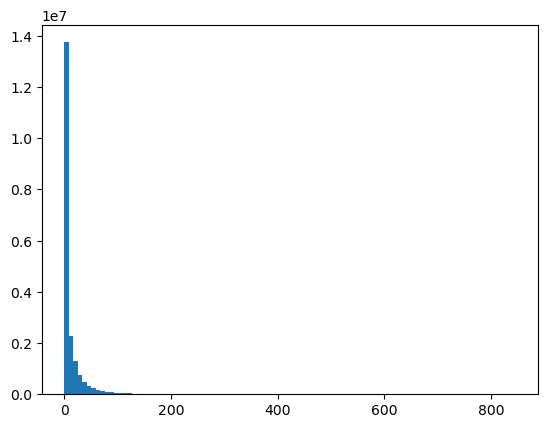

In [51]:
_=plt.hist(asl_warped.numpy().flatten(), bins=100)
asl_warped.to_file("asl_registered_v2.nii.gz")

In [31]:
# reg["warpedmovout"].to_file("ASL_registered_to_T1.nii.gz")
asl_warped = ants.apply_transforms(
    fixed=t1,
    moving=asl,  # original ASL image, not normalized
    transformlist=reg["fwdtransforms"]
)
asl_warped.to_file("ASL_registered_to_T1_v2.nii.gz")
asl_warped.max()


4.420166e-36

In [ ]:
# Read images

# Normalize intensity (optional, can improve MI registration)
asl_norm = ants.iMath(asl, "Normalize")
t1_norm = ants.iMath(t1, "Normalize")

# Register
reg = ants.registration(fixed=t1_norm, moving=asl_norm, type_of_transform="Affine")

# Save result
reg["warpedmovout"].to_file("ASL_registered_to_T1.nii.gz")

In [45]:
tmp_output_dir = output_dir

if not tmp_output_dir.exists():
    os.makedirs(tmp_output_dir)

source_img = ants.image_read(str(target))
target_img = ants.image_read(str(source))
syn_flow_sigma = 4.0
syn_total_sigma = 3.0

pre_to_post_rigid = ants.registration(fixed=target_img, moving=source_img, type_of_transform='SyNBold', outprefix=str(tmp_output_dir)+"/") #run rigid
pre_aligned = ants.apply_transforms(fixed=target_img, moving=source_img, transformlist=pre_to_post_rigid['fwdtransforms']) #apply rigid
ants.image_write(pre_aligned, str(tmp_output_dir) + "/pre_aligned.nii.gz") 

# reg_aligned = do_reg([source], [target], file_name=output, output_dir=output_dir, run_syn=run_syn, scaling_factor=scaling_factor)
# save_volume(output, load_volume(reg_aligned['transformed_source']) ,overwrite_file=True)

# pre_to_post_nonlin = ants.registration(fixed=target_img, moving=pre_aligned, 
#                                         type_of_transform='SyNOnly',
#                                         initial_transform='Identity',
#                                         flow_sigma=syn_flow_sigma,
#                                         total_sigma=syn_total_sigma,
#                                         outprefix=tmp_output_dir+"/")

In [ ]:
ants.image_write(pre_aligned, str(tmp_output_dir) + "/pre_aligned.nii.gz") 


In [48]:
ants.image_write(pre_to_post_rigid['warpedmovout'], str(tmp_output_dir) + "/pre_aligned_rigid.nii.gz")


In [4]:
# === Step 1: Load your images ===
asl_img = source_img     # moving image
struct_img = ants.image_read(str(target))  # fixed image (could be t2w.nii.gz)

# === Step 2: Perform registration ===
reg = ants.registration(
    fixed=struct_img,
    moving=asl_img,
    type_of_transform="Rigid",  # or "Affine" or "Rigid" depending on your needs
    verbose=True
)

# === Step 3: Apply the transform to the ASL image ===
asl_registered = reg['warpedmovout']
ants.image_write(asl_registered, str(output_dir) + "/asl_to_struct_registered.nii.gz")

# Optional: Save the transformation parameters
reg['fwdtransforms']  # List of forward transformation files
reg['invtransforms']  # List of inverse transformation files

antsRegistration -d 3 -r [0x73e831e91f48,0x73e831e91ba8,1] -m mattes[0x73e831e91f48,0x73e831e91ba8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [/tmp/tmpyjase5vo,0x73e831e92028,0x73e831e91e88] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x73e831e91f48 and moving image: 0x73e831e91ba8 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 4
  fixed image: 0x73e831e91f48
  moving image: 0x73e831e91ba8
Dimension = 3
Number of stages = 1
Use histogram matching = true
Winsorize image intensities = false
  Lower quantile = 0
  Upper quantile = 1


Stage 1 State
   Image metric = MattesMI
     Fixed image = Image (0x55b278707980)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference 

['/tmp/tmpyjase5vo0GenericAffine.mat']

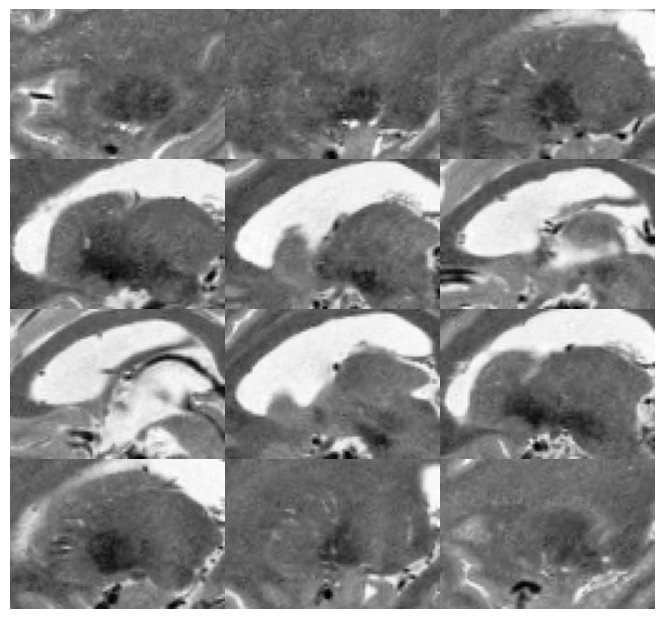

In [6]:
reg['warpedfixout'].plot()

antsRegistration -d 3 -r [0x770ea5a522a8,0x770ea5a52468,1] -m mattes[0x770ea5a522a8,0x770ea5a52468,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [/tmp/tmpj830645m,0x770ea5a52ea8,0x770ea5a52ee8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x770ea5a522a8 and moving image: 0x770ea5a52468 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 4
  fixed image: 0x770ea5a522a8
  moving image: 0x770ea5a52468
Dimension = 3
Number of stages = 1
Use histogram matching = true
Winsorize image intensities = false
  Lower quantile = 0.0000e+00
  Upper quantile = 1.0000e+00


Stage 1 State
   Image metric = MattesMI
     Fixed image = Image (0x639026f400e0)
  RTTI typeinfo:   itk::Image<float

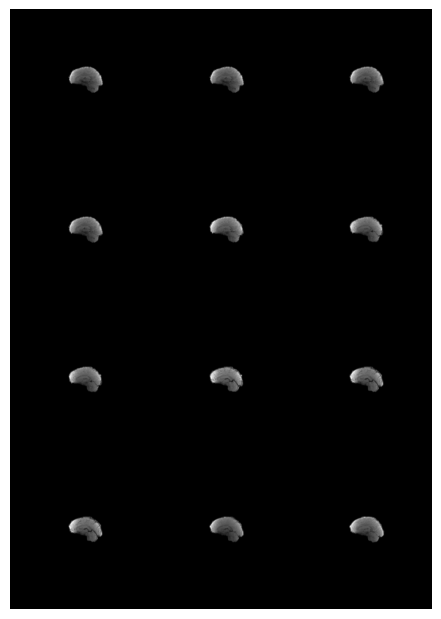

In [ ]:

# Load fixed and moving
t1_target = os.path.join('/home/chris/Downloads/HCPA/HCA6010538_V1_MR/unprocessed/T1w_MPR_vNav_4e_e1e2_mean','HCA6010538_V1_MR_T1w_MPR_vNav_4e_e1e2_mean_bet.nii.gz')
t1 = ants.image_read(str(target))
asl = source_img

# Resample ASL to T1 *before* setting geometry (important!)
# asl_resampled = ants.resample_image(asl, t1.shape, use_voxels=True)

# # Now copy geometry from T1 to resampled ASL
# asl_resampled.set_spacing(t1.spacing)
# asl_resampled.set_origin(t1.origin)
# asl_resampled.set_direction(t1.direction)

# Optional: intensity normalize
# asl_norm = ants.iMath(asl_resampled, "Normalize")

# Register
reg = ants.registration(fixed=t1, moving=asl, type_of_transform="Rigid", verbose=True)
reg['warpedmovout'].plot()
ants.image_write(reg['warpedmovout'], str(output_dir) + "/asl_to_struct_registered.nii.gz")


In [12]:
print("ASL shape:", asl.shape)
print("ASL spacing:", asl.spacing)
print("ASL origin:", asl.origin)

print("T1 shape:", t1.shape)
print("T1 spacing:", t1.spacing)
print("T1 origin:", t1.origin)

ASL shape: (86, 86, 60)
ASL spacing: (0.7999971508979797, 0.800000011920929, 0.800000011920929)
ASL origin: (84.00028991699219, 28.83385467529297, -159.84890747070312)
T1 shape: (208, 300, 320)
T1 spacing: (0.7999971508979797, 0.800000011920929, 0.800000011920929)
T1 origin: (84.00028991699219, 28.83385467529297, -159.84890747070312)


Warped output mean intensity: 6.749305


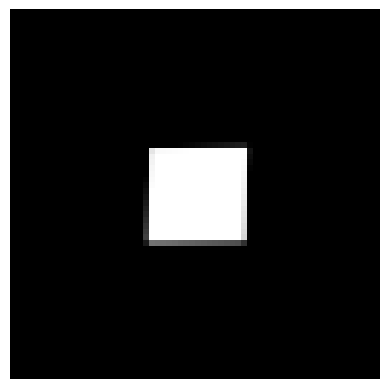

In [5]:
import ants

# Create a synthetic image with a bright square in the center
img = ants.make_image((64, 64), voxval=0)
img[24:40, 24:40] = 100

# Apply a shift (translation)
tx = ants.create_ants_transform(transform_type='Euler2DTransform', dimension=2)
tx.set_parameters([0, 5, 5])  # rotation + translation

shifted = ants.apply_ants_transform_to_image(tx, img, img)

# Register shifted image back to original
reg = ants.registration(fixed=img, moving=shifted, type_of_transform="Affine")
print("Warped output mean intensity:", reg["warpedmovout"].mean())
ants.plot(reg["warpedmovout"])

In [14]:
# Read images

# Normalize intensity (optional, can improve MI registration)
asl_norm = ants.iMath(asl, "Normalize")
t1_norm = ants.iMath(t1, "Normalize")

# Register
reg = ants.registration(fixed=t1_norm, moving=asl_norm, type_of_transform="Affine")

# Save result
reg["warpedmovout"].to_file("ASL_registered_to_T1.nii.gz")